In [1]:
from sklearn import datasets, model_selection
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import random
from IPython.core.display import display, HTML
import warnings
import time
sns.set()
display(HTML("<style>.container { width:60% !important; }</style>"))  # увеличение ширины ячейки блокнота
warnings.filterwarnings("ignore",category=UserWarning)  # убираем ненужные предупреждение matplotlib

In [15]:
def gb_predict(X, trees_list, coef_list, eta):
    """
    Функция, реализующая предсказание в градиентном бустинге.
    Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    прибавляются с шагом eta
    """
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

def mean_squared_error(y_real, prediction):
    """
    Расчет среднеквадратической ошибки MSE
    """
    try:
        return (sum((y_real - prediction)**2)) / len(y_real)
    except:
        return (sum((y_real - prediction)**2)) / 1

def bias(y, z):
    """
    Производная от функции ошибки MSE
    Используется для расчета градиента
    """
    return (y - z)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """
    Функция обучения градиентного бустинга
    """
    # Запись деревьев в список
    trees = []
    # Запись ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
    return trees, train_errors, test_errors

def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

def ntrees_error_plot(n_trees, train_err, test_err):
    """
    График зависимости ошибки на обучающей и тестовой выборках от числа итераций (деревьев)
    """
    plt.title('Зависимость ошибки от числа деревьев')
    plt.xlabel('Trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [3]:
# Загрузка датасета
X, y = datasets.load_diabetes(return_X_y=True)

# Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
%%time
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 80.50413704330126
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4335.850086306945
CPU times: user 2min 40s, sys: 25.6 ms, total: 2min 40s
Wall time: 2min 40s


***
***
***
Так как построение графика зависимости ошибки MSE от глубины деревьев требует длительного обучения с различной глубиной деревьев, следует в начале ускорить алгоритм обучения, сделав его стохастическим.

# 2
Модифицировать алгоритм, чтобы получился стохастический градиентый бустинг. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций

In [5]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, qty_in_batch=len(X_test) // n_trees):
    """
    Функция обучения стохастического градиентного бустинга
    qty_in_batch -- количество наблюдений в подвыборке
    """
    # Считаем сколько всего может быть подвыборок из заданного кол-во элементов в подвыборке qty_in_batch
    n_batch = len(X_test) // qty_in_batch
    if n_batch % qty_in_batch != 0:
        n_batch += 1
    
    # Запись деревьев в список
    trees = []
    # Запись ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    b = 0 # номер подвыборки
    for i in range(n_trees):
        # если подвыборок меньше, чеем количество деревьев, то нужно начинать вновь с первой подвыборки
        if not b in range(n_batch):
            b = 0
        # формируем обучающую и тестовую подвыборку -- приставка _st (стохастический)
        start_ = qty_in_batch*b
        end_ = qty_in_batch*(b+1)
        X_train_st = X_train[start_ : end_]
        y_train_st = y_train[start_ : end_]
        X_test_st = X_test[start_ : end_]
        y_test_st = y_test[start_ : end_]
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            train_errors.append(mean_squared_error(y_train_st, gb_predict(X_train_st, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test_st, gb_predict(X_test_st, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_st, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_st, bias(y_train_st, target))
            train_errors.append(mean_squared_error(y_train_st, gb_predict(X_train_st, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test_st, gb_predict(X_test_st, trees, coefs, eta)))
        trees.append(tree)
        b += 1
    return trees, train_errors, test_errors

2 is done in 0.0 min!
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 3686.814309789434
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4897.083685197808


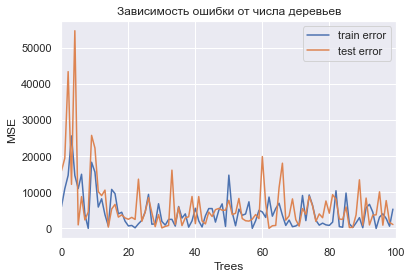

4 is done in 0.0 min!
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 3761.306051227749
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 5647.079039817351


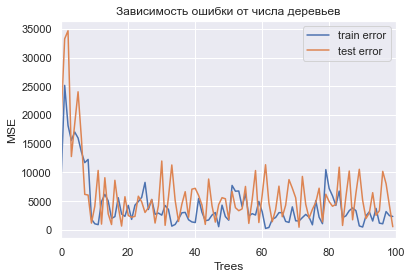

10 is done in 0.1 min!
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 3904.0768790324487
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 6109.571831059122


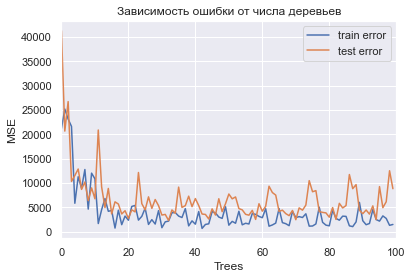

In [6]:
n_trees = 100  # Число деревьев в ансамбле
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
max_depth = 5  # Максимальная глубина деревьев
eta = 0.1  # Шаг
qtys_in_batch = [2, 4, 10]  # количество элементов в подвыборке
sgb_results = []
for qty_in_batch in qtys_in_batch:
    start_time = time.time()
    print(qty_in_batch, end=' ')
    sgb_results.append(sgb_fit(
                       n_trees=n_trees, 
                       max_depth=max_depth, 
                       X_train=X_train, 
                       X_test=X_test, 
                       y_train=y_train, 
                       y_test=y_test, 
                       coefs=coefs, 
                       eta=eta, 
                       qty_in_batch=qty_in_batch))
    print(f'is done in {round((time.time() - start_time)/60, 1)} min!')
    evaluate_alg(X_train, X_test, y_train, y_test, sgb_results[-1][0], coefs, eta)
    ntrees_error_plot(n_trees, train_err=sgb_results[-1][1], test_err=sgb_results[-1][2])

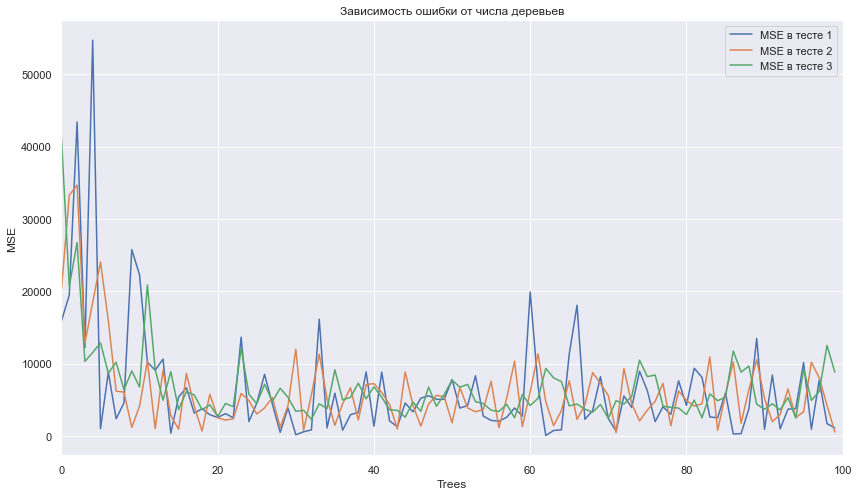

In [7]:
# Сравнение ошибок (по тестовой выборке) в зависимости от размера подвыборки стохастического градиентого бустинга
plt.figure(figsize=(14,8))
plt.title('Зависимость ошибки от числа деревьев')
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
for i in range(len(sgb_results)):
    plt.plot(list(range(n_trees)), sgb_results[i][2], label=f'MSE в тесте {i+1}')
plt.legend(loc='upper right')
plt.show()

Нибольшая точность (в рамках данных тестов) достигается при 4 элементах в подвыборках.  
При этом, увеличение числа элементов приводит к ухудшеению точности, но уменьшению разброса ошибок.

# 1
Построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.  
Сделать выводы.

In [8]:
def ntrees_error_plot(n_trees, train_err, test_err):
    """
    График зависимости ошибки на обучающей и тестовой выборках от числа итераций (деревьев)
    """
    plt.title('Зависимость ошибки от числа деревьев')
    plt.xlabel('Trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()
    
def depth_error_plot(depths_result):
    """
    График зависимости ошибки на обучающей и тестовой выборках от глубины деревьев
    """
    test_errors = []
    for i in depths_result.keys():
        test_errors.append(depths_result[i][2][-1])  # берем итоговую ошибку
    plt.figure(figsize=(14,8))
    plt.title('Зависимость ошибки от глубины деревьев')
    plt.xlabel('Глубина деревьев')
    plt.ylabel('MSE')
    plt.plot(depths_result.keys(), test_errors, label=f'test_error')
    plt.legend(loc='upper right')

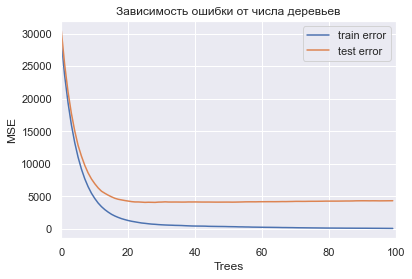

In [13]:
# график зависимости ошибки от количества деревьев
ntrees_error_plot(n_trees, train_errors, test_errors)

In [16]:
# Соберем результаты с разной глубиной деревьев, используя стохастический градиентный бустинг
n_trees = 100  # Число деревьев в ансамбле
eta = 0.1  # Шаг
depths = [1, 3, 5, 7, 10, 20]  # Максимальная глубина деревьев
depths_result = {}
for max_depth in depths:
    start_time = time.time()
    print(max_depth, end=' ')
    d_trees, d_train_errors, d_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, qty_in_batch=3)
    depths_result[max_depth] = [d_trees, d_train_errors, d_test_errors]
    print(f'is done in {round((time.time() - start_time)/60, 3)} min!')

1 is done in 0.031 min!
3 is done in 0.03 min!
5 is done in 0.031 min!
7 is done in 0.031 min!
10 is done in 0.031 min!
20 is done in 0.031 min!


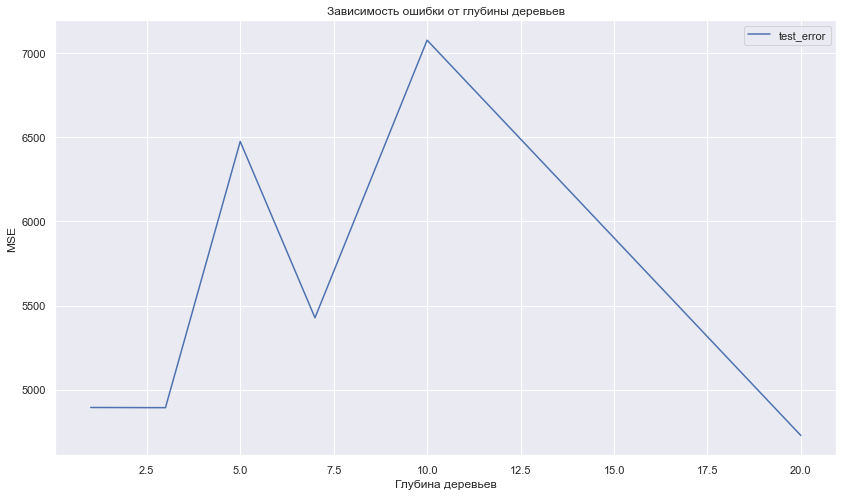

In [17]:
# График зависимости ошибки на обучающей и тестовой выборках от глубины деревьев
depth_error_plot(depths_result)

Оптимальная глубина деревьев -- 3. При большей глубине деревьев ошибка увеличивается, при слишком высоком значении глубины дерева значение ошибки сильно снижается -- возможно переобучение.